In [1]:
import jax.numpy as jnp
import jax.random as jr
import jax

import imageio
import os

In [136]:
def boids_simulation(num_boids, num_steps, seperation, separation_radius, alignment, alignment_radius, cohesion, cohesion_radius, rng_key, space_size=50.0, max_velocity=0.3, min_velocity=0.1, avoid_edges=False, edge_avoidance_strength=1.0):
    """ 
    Simulate the movement of boids in a 2D toroidal space with velocity constraints.
    
    Args:
        num_boids (int): Number of boids in the simulation.
        num_steps (int): Number of simulation steps.
        seperation (float): Weight for the separation behavior.
        separation_radius (float): Radius for the separation behavior.
        alignment (float): Weight for the alignment behavior.
        alignment_radius (float): Radius for the alignment behavior.
        cohesion (float): Weight for the cohesion behavior.
        cohesion_radius (float): Radius for the cohesion behavior.
        rng_key (jax.random.PRNGKey): Random key for initialization.
        space_size (float): Size of the 2D toroidal space.
        max_velocity (float): Maximum allowed velocity magnitude.
        min_velocity (float): Minimum allowed velocity magnitude.
        avoid_edges (bool): Whether to apply edge avoidance behavior.
        edge_avoidance_strength (float): Strength of the edge avoidance force.

    Returns:
        position_history (jax.numpy.ndarray): History of positions at each step.
        velocity_history (jax.numpy.ndarray): History of velocities at each step.
        positions (jax.numpy.ndarray): Final positions of the boids.
        velocities (jax.numpy.ndarray): Final velocities of the boids.
    """
    # Initialize positions and velocities of boids
    positions = jr.uniform(rng_key, (num_boids, 2), minval=space_size//4, maxval=space_size - space_size//4)
    velocities = jr.uniform(rng_key, (num_boids, 2), minval=-0.1, maxval=0.1)
    
    def step(carry, _):
        positions, velocities = carry
        diff = positions[:, None, :] - positions[None, :, :]  # Pairwise differences
        distances = jnp.linalg.norm(diff, axis=-1)  # Pairwise distances

        # Masks for different radii
        separation_mask = (distances < separation_radius)
        alignment_mask = (distances < alignment_radius)
        cohesion_mask = (distances < cohesion_radius)

        # Separation: Avoid nearby boids
        separation_vector = jnp.sum(jnp.where(separation_mask[..., None], -diff, 0.0), axis=1)

        # Alignment: Match velocity with neighbors
        local_avg_velocity = jnp.sum(jnp.where(alignment_mask[..., None], velocities[None, :, :], 0.0), axis=1) / jnp.sum(alignment_mask, axis=1, keepdims=True)
        alignment_vector = local_avg_velocity - velocities

        # Cohesion: Move toward local center of mass
        local_center_of_mass = jnp.sum(jnp.where(cohesion_mask[..., None], positions[None, :, :], 0.0), axis=1) / jnp.sum(cohesion_mask, axis=1, keepdims=True)
        cohesion_vector = local_center_of_mass - positions

        # Edge avoidance: Push boids away from edges
        edge_avoidance_vector = jnp.zeros_like(positions)
        if avoid_edges:
            edge_threshold = space_size * 0.1  # Threshold distance from edges
            edge_avoidance_vector += jnp.where(positions < edge_threshold, edge_avoidance_strength * (edge_threshold - positions), 0.0)
            edge_avoidance_vector += jnp.where(positions > space_size - edge_threshold, edge_avoidance_strength * (space_size - edge_threshold - positions), 0.0)

        # Update velocities
        velocities += (seperation * separation_vector +
                       alignment * alignment_vector +
                       cohesion * cohesion_vector +
                       edge_avoidance_vector) / num_boids

        # Clamp velocities to the specified range
        velocity_magnitudes = jnp.linalg.norm(velocities, axis=1, keepdims=True)
        velocities = jnp.where(velocity_magnitudes > max_velocity, velocities * (max_velocity / velocity_magnitudes), velocities)
        velocities = jnp.where(velocity_magnitudes < min_velocity, velocities * (min_velocity / velocity_magnitudes), velocities)

        # Update positions
        positions += velocities

        # Apply toroidal wrapping
        positions = jnp.mod(positions, space_size)

        return (positions, velocities), (positions, velocities)
    
    # Use lax.scan to run the simulation for the specified number of steps
    (final_positions, final_velocities), (position_history, velocity_history) = jax.lax.scan(
        step, (positions, velocities), None, length=num_steps
    )
    
    return position_history, velocity_history, final_positions, final_velocities

In [146]:
num_boids = 400
num_steps = 2000
seperation = 0.02
alignment = 0.6
cohesion = 0.5
separation_radius = 3.0
alignment_radius = 10.0
cohesion_radius = 10.0
rng_key = jr.PRNGKey(0)

# Enable edge avoidance
avoid_edges = True
edge_avoidance_strength = 1.0

# Run the simulation
position_history, velocity_history, final_positions, final_velocities = boids_simulation(
    num_boids, num_steps, seperation, separation_radius, alignment, alignment_radius, cohesion, cohesion_radius, rng_key, avoid_edges=avoid_edges, edge_avoidance_strength=edge_avoidance_strength
)

In [147]:
# plot the positions and use the color for the velocities
import matplotlib.pyplot as plt
import numpy as np
# Convert JAX arrays to NumPy for plotting
position_history_np = jnp.array(position_history)
velocity_history_np = jnp.array(velocity_history)
abs_velocities = jnp.linalg.norm(velocity_history_np, axis=-1)
# Normalize the velocities for color mapping
velocity_history_np = (velocity_history_np - velocity_history_np.min()) / (velocity_history_np.max() - velocity_history_np.min())

/var/folders/_t/k7g7kxnn08gbcw98nd8r1qq40000gn/T/ipykernel_2124/643884501.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(position_history_np[step, :, 0], position_history_np[step, :, 1], cmap='viridis', s=10)


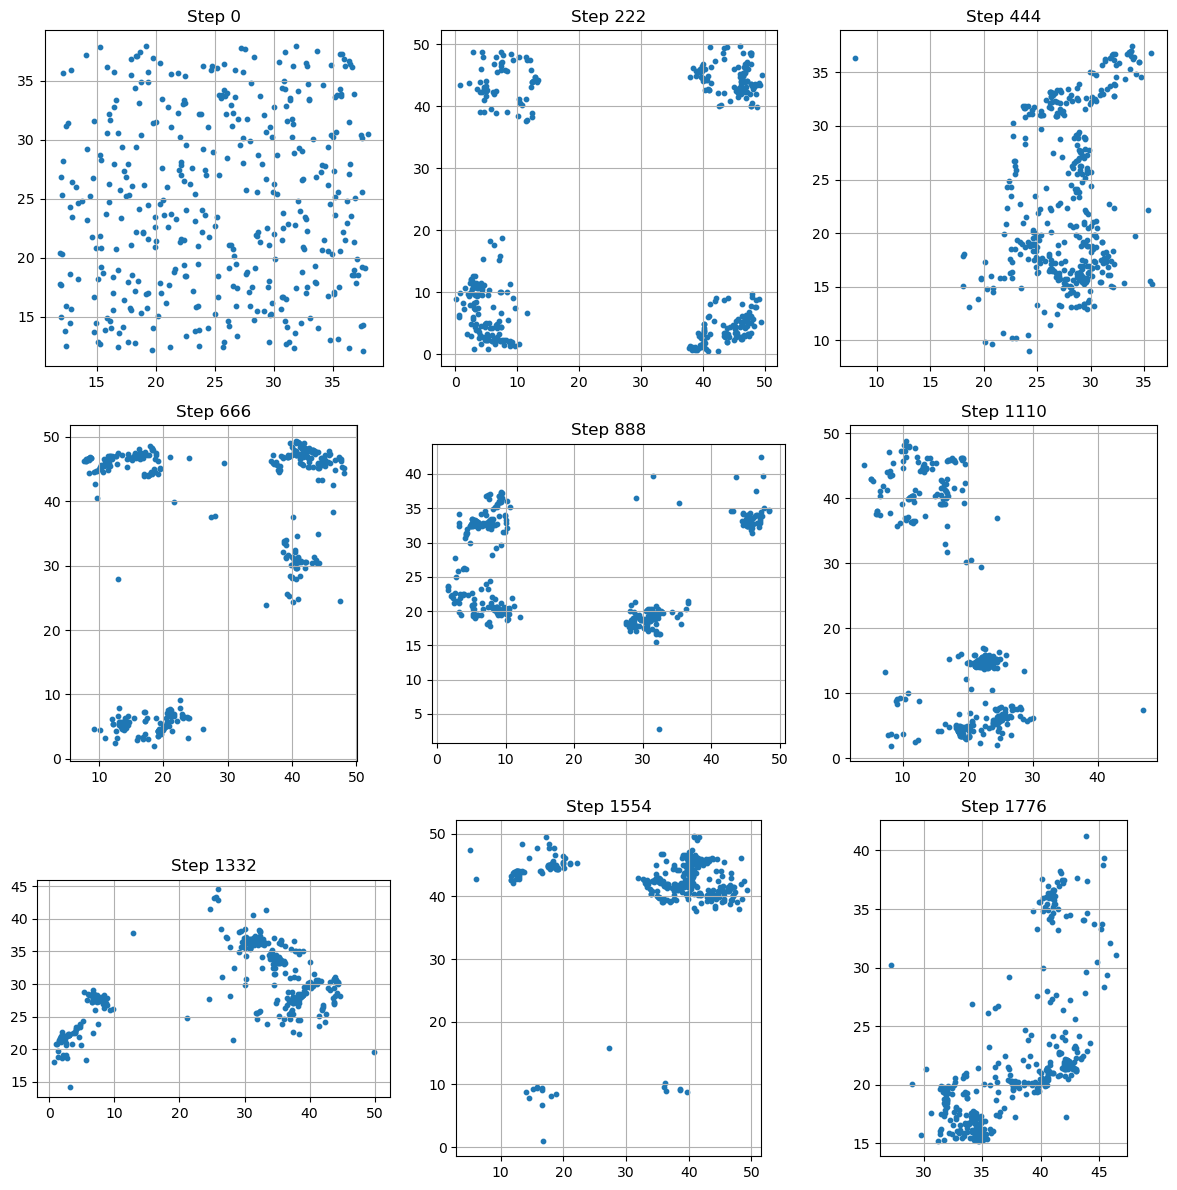

In [148]:
# Plot the simulation at 9 different time points in a 3x3 grid
use_velocity = False
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    step = i * (num_steps // 9)
    ax.set_title(f"Step {step}")
    # ax.set_xlim(0, 10)
    # ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    # ax.set_xticks(np.arange(0, 11, 1))
    # ax.set_yticks(np.arange(0, 11, 1))
    ax.grid()
    # Plot the boids
    if use_velocity:
        ax.quiver(position_history_np[step, :, 0], position_history_np[step, :, 1],
                velocity_history_np[step, :, 0], velocity_history_np[step, :, 1],
                angles='xy', scale_units='xy', scale=1)
    else:
        ax.scatter(position_history_np[step, :, 0], position_history_np[step, :, 1], cmap='viridis', s=10)
plt.tight_layout()
plt.show()

In [149]:
def create_gif(position_history, velocity_history, filename='boids_simulation.gif', fps=5, frame_step=10, use_arrows=True, window_size=50):
    """
    Create a GIF from the boids simulation.
    
    Args:
        position_history (jax.numpy.ndarray): History of positions at each step.
        velocity_history (jax.numpy.ndarray): History of velocities at each step.
        filename (str): Name of the output GIF file.
        fps (int): Frames per second for the GIF.
        frame_step (int): Step size for selecting frames (e.g., every nth frame).
    """
    images = []
    for i in range(0, position_history.shape[0], frame_step):
        fig, ax = plt.subplots()
        ax.set_xlim(0, window_size)
        ax.set_ylim(0, window_size)
        ax.set_aspect('equal')
        ax.set_xticks(np.arange(0, window_size + window_size % 10, window_size // 10))
        ax.set_yticks(np.arange(0, window_size + window_size % 10, window_size // 10))
        ax.grid()
        # Plot the boids as arrows with consistent size and adjustable width
        if use_arrows:
            ax.quiver(position_history[i, :, 0], position_history[i, :, 1],
                      velocity_history[i, :, 0], velocity_history[i, :, 1],
                      angles='xy', scale_units='xy', scale=5, width=0.005, color='blue')  # Fixed scale and width
        else:
            ax.scatter(position_history[i, :, 0], position_history[i, :, 1], cmap='viridis', s=10)
        plt.title(f"Step {i}")
        plt.tight_layout()
        # Save the current frame
        temp_filename = f"frame_{i}.png"
        plt.savefig(temp_filename)
        images.append(imageio.imread(temp_filename))
        plt.close(fig)
    # Create a GIF from the images
    imageio.mimsave(filename, images, fps=fps)
    # Clean up temporary files
    for temp_filename in [f"frame_{i}.png" for i in range(0, position_history.shape[0], frame_step)]:
        if os.path.exists(temp_filename):
            os.remove(temp_filename)

# Create the GIF with every 10th frame
create_gif(position_history, velocity_history, filename='boids_simulation.gif', fps=10, frame_step=10)

/var/folders/_t/k7g7kxnn08gbcw98nd8r1qq40000gn/T/ipykernel_2124/2708879041.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_filename))


In [142]:
for temp_filename in [f"frame_{i}.png" for i in range(0, position_history.shape[0], 10)]:
    if os.path.exists(temp_filename):
        os.remove(temp_filename)